# HMS Capstone - Machine Learning - Random Forests
## By: AJ Goldstein (https://github.com/ajva1996)

### <span style="color:red">Modeling Task: </span>
### Understand the relationship between psychological inflexibility (i.e. AAQ) and mental health outcomes (i.e. depression, anxiety, well-being) while controlling for key demographic info (i.e. race, gender, field of study)

### <span style="color:red">Why Random Forests?</span>
- WHY 1: <b>high interpretability & stable feature importances</b>
- WHY 2: <b>reduces variance & prevents overfitting</b>
- WHY 3: <b>inherently models feature interactions</b>

### <span style="color:red">Analysis Steps:</span>
- 1) Prepare data for classification
- 2) Train a Random Forest Classifier
- 3) Optimize Classifier Models
- 4) Train a Random Forest Regressor

In [650]:
from __future__ import division
import pandas as pd
import numpy as np
from scipy.stats import spearmanr

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")
sns.set_context("talk")

import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score
from sklearn.dummy import DummyClassifier, DummyRegressor

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

## STEP #0: Carry forward data from previous notebook

In [574]:
# cleaned dataset
%store -r HMS

# separated modules
%store -r HMS_ids
%store -r HMS_demo
%store -r HMS_mhstatus
%store -r HMS_mhhelp
%store -r HMS_aaq

# tidy variable groups
%store -r tidy_race
%store -r tidy_religion
%store -r tidy_degreeType
%store -r tidy_fieldOfStudy
%store -r tidy_activity
%store -r tidy_age
%store -r tidy_gender
%store -r tidy_relig

## STEP #1: Prepare data for classification

### a) convert survey demographics & AAQ into features matrix (X)

In [575]:
# select columns without text 
cols = [col for col in HMS_demo.columns if ('text' not in col)]
X = HMS_demo[cols].fillna(0)

In [576]:
# convert them to categorical variables
for col in cols:
    X[col] = X[col].astype('category')

In [577]:
# add in AAQ_total score
X.insert(loc=0, column = 'AAQ', value = HMS_aaq['AAQ_total'])
feat_cols = X.columns

X.head()

,AAQ,age,sex_birth,gender,sexual,relship,race_black,race_ainaan,race_asian,race_his_temp,...,disab_1_1,disab_1_2,disab_1_3,disab_1_4,disab_1_5,disab_1_6,disab_1_7,disab_1_8,disab_1_9,disab_3
0,NaN,20.0,1.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,NaN,21.0,1.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
3,NaN,22.0,2.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,NaN,19.0,2.0,1.0,1.0,6.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,NaN,21.0,2.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### b) remove unapplicable and missing values (NaN's)

In [578]:
# select three main outcomes
Y_flourish = HMS_mhstatus['flourish']
Y_depression = HMS_mhstatus['deprawsc']
Y_anxiety = HMS_mhstatus['anx_score']

In [579]:
# combine all variables (X's and Y's) into one dataframe
all_variables = pd.concat([X, Y_flourish, Y_depression, Y_anxiety], axis = 1)

In [580]:
# remove all rows with any NaN
print('shape before removing NaNs:', all_variables.shape)
all_variables = all_variables.dropna(axis=0, how='any')
print('shape after removing NaNs:', all_variables.shape) # NOTE: 25,000+ dropped rows were due to AAQ

('shape before removing NaNs:', (45756, 103))
('shape after removing NaNs:', (22781, 103))


#### <span style="color:red"> IMPORTANT NOTE: 25,000+ dropped rows were due to AAQ (half of respondents did not have an AAQ score)</span>

In [581]:
# remove middle 1/3 of scores in the "mild" range
print('shape BEFORE removing middle 1/3 of scores:', all_variables.shape)
all_variables = all_variables.loc[~all_variables['flourish'].between(42, 47, inclusive=True)]
all_variables = all_variables.loc[~all_variables['deprawsc'].between(5, 9, inclusive=True)]
all_variables = all_variables.loc[~all_variables['anx_score'].between(5, 9, inclusive=True)]
print('shape AFTER removing middle 1/3 of scores:', all_variables.shape)

('shape BEFORE removing middle 1/3 of scores:', (22781, 103))
('shape AFTER removing middle 1/3 of scores:', (8972, 103))


#### <span style="color:red"> IMPORTANT NOTE: 13,000 rows were dropped from the "mild" range of these scores</span>

In [582]:
# split big dataframe back up
X = all_variables.drop(labels=['flourish', 'deprawsc', 'anx_score'], axis=1)
Y_flourish_cleaned = all_variables['flourish']
Y_depression_cleaned = all_variables['deprawsc']
Y_anxiety_cleaned = all_variables['anx_score']

### c) categorize mental health outcomes into classified labels (Y)

In [583]:
def categorize_outcome(value, outcome):
    
    # flourishing scale
    if outcome == 'flourish':
        if pd.isnull(value):
            return value
        elif value < 48:
            return 0
        elif value >= 48:
            return 1
        
    # depression or anxiety
    else:
        if pd.isnull(value):
            return value
        elif value < 10:
            return 0
        elif value >= 10:
            return 1

In [584]:
# convert to categorical labels
Y_flourish_cats = pd.Series([categorize_outcome(score, 'flourish') for score in Y_flourish_cleaned], name='flourish')
Y_depression_cats = pd.Series([categorize_outcome(score, 'depression') for score in Y_depression_cleaned], name = 'depression')
Y_anxiety_cats = pd.Series([categorize_outcome(score, 'anxiety') for score in Y_anxiety_cleaned], name = 'anxiety')

#### <span style="color:red">NOTE: using "moderate" score of 10 as cutoff for depression/anxiety... 48 as the threshold for positive mental health</span>

## STEP #2: Train a Random Forest Classifier

### a) split data into train & test sets

In [617]:
# split the data into training and test sets
X_train, X_test = train_test_split(X, test_size=0.3, random_state=0)
y_flourish_train, y_flourish_test = train_test_split(Y_flourish_cats, test_size=0.3, random_state=0)
y_depression_train, y_depression_test = train_test_split(Y_depression_cats, test_size=0.3, random_state=0)
y_anxiety_train, y_anxiety_test = train_test_split(Y_anxiety_cats, test_size=0.3, random_state=0)

### b) create and train the classifier

In [618]:
# Create random forest classifiers
dep_clf = RandomForestClassifier(n_estimators=1000, max_features = "auto", max_depth = 5,
                             min_samples_leaf = 100, random_state=0, n_jobs=-1)

anx_clf = RandomForestClassifier(n_estimators=1000, max_features = "auto", max_depth = 5,
                             min_samples_leaf = 100, random_state=0, n_jobs=-1)

flo_clf = RandomForestClassifier(n_estimators=1000, max_features = "auto", max_depth = 5,
                             min_samples_leaf = 100, random_state=0, n_jobs=-1)

In [619]:
# Train the classifier on all three outcomes
dep_clf.fit(X_train, y_depression_train)
anx_clf.fit(X_train, y_anxiety_train)
flo_clf.fit(X_train, y_flourish_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=100, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

### c) extract feature importances

In [623]:
from IPython.display import display, HTML

In [841]:
# Print the name and gini importance of each feature
for clf in [dep_clf, anx_clf, flo_clf]:
    features = pd.DataFrame(sorted(zip(feat_cols, clf.feature_importances_),
                            key=lambda x: x[1], reverse=True), columns = ['name', 'importance'])
    #display(features.head(10))
    if clf == dep_clf:
        display(features.head(10))

,name,importance
0,AAQ,0.366570
1,aca_impa,0.269347
2,persist,0.106480
3,fincur,0.093753
4,sexual,0.044024
5,finpast,0.031884
6,gpa_sr,0.017441
7,religios,0.010687
8,gender,0.009129
9,relig_aff_ch,0.006497


### <span style="color:red">AAQ consistently comes out on top as by far the most important feature</span>
- #### <span style="color:red">(10x more important than any variable outside the top 5 in predicting mental health outcomes)</span>

### d) test the accuracy of our full-feature classifier

In [636]:
# Apply The Full Featured Classifier To The Test Data
y_pred_dep = dep_clf.predict(X_test)
y_pred_anx = anx_clf.predict(X_test)
y_pred_flo = flo_clf.predict(X_test)

# Print the Accuracy Of Our Full Feature Model
print('Depression Model Accuracy:', accuracy_score(y_depression_test, y_pred_dep))
print('Anxiety Model Accuracy:', accuracy_score(y_anxiety_test, y_pred_anx))
print('Flourishing Model Accuracy:', accuracy_score(y_flourish_test, y_pred_flo))

('Depression Model Accuracy:', 0.90973254086181277)
('Anxiety Model Accuracy:', 0.89635958395245174)
('Flourishing Model Accuracy:', 0.84658246656760772)


### e) perform cross-validation to check for possible overfitting

In [842]:
from sklearn import model_selection
from sklearn.model_selection import cross_val_score
kfold = model_selection.KFold(n_splits=10, random_state=7)
for modelCV, trainingData in zip([dep_clf, anx_clf, flo_clf], [y_depression_train, y_anxiety_train, y_flourish_train]):
    results = model_selection.cross_val_score(modelCV, X_train, trainingData, cv=kfold, scoring='accuracy')
    print("10-fold cross validation average accuracy: %.3f" % (results.mean()))

10-fold cross validation average accuracy: 0.904
10-fold cross validation average accuracy: 0.895
10-fold cross validation average accuracy: 0.847


### f) compare performance to baseline measure (dummyClassifier)

In [655]:
# Question: "what if we just guessed the *most common class* everytime?"
y_mode_pred_dep = DummyClassifier(strategy='most_frequent').fit(X_train, y_depression_train).predict(X_test)
y_mode_pred_anx = DummyClassifier(strategy='most_frequent').fit(X_train, y_anxiety_train).predict(X_test)
y_mode_pred_flo = DummyClassifier(strategy='most_frequent').fit(X_train, y_flourish_train).predict(X_test)

# use arrays of mode values to make baseline predictions
print('Depression BASELINE Accuracy:', accuracy_score(y_depression_test, y_mode_pred_dep))
print('Anxiety BASELINE Accuracy:', accuracy_score(y_anxiety_test, y_mode_pred_anx))
print('Flourishing BASELINE Accuracy:', accuracy_score(y_flourish_test, y_mode_pred_flo))

('Depression BASELINE Accuracy:', 0.54866270430906394)
('Anxiety BASELINE Accuracy:', 0.57206537890044573)
('Flourishing BASELINE Accuracy:', 0.56723625557206536)


### <span style="color:red"> The predictive models created above are 35-40% more accurate than their baseline measures: </span>
- #### <span style="color:red">Depression Classifer: ~92% accuracy</span> in predicting whether or not a student is clinically depressed
- #### <span style="color:red">Anxiety Classifer: ~90% accuracy </span>in predicting whether or not a student has general anxiety disorder
- #### <span style="color:red">Flourishing Classifer: ~85% accuracy </span>in predicting whether or not someone has positive mental health

## STEP #3: Optimize Classifier Models

### a) optimize hyperparameters using GridSearch

In [685]:
from sklearn.grid_search import GridSearchCV
 
rfc = RandomForestClassifier(n_jobs=-1, oob_score = True) 
 
# Use a grid over parameters of interest
param_grid = {"criterion" : ['gini', 'entropy'],
              "n_estimators" : [500, 1000],
              "max_depth" : [3, 5, 10, 15],
              "max_features" : [6, 8, 10, 12],
              "min_samples_leaf" : [10, 30, 50, 100]}
 
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=5)
CV_rfc.fit(X_train, y_depression_train)
print CV_rfc.best_params_

{'max_features': 12, 'n_estimators': 1000, 'criterion': 'entropy', 'max_depth': 15, 'min_samples_leaf': 10}


### b) identify and select the most important features

In [843]:
# Create a selector object that will use the random forest classifier to identify
# features that have an importance of more than 0
sfm = SelectFromModel(clf, threshold=0.03)

# Train the selector
sfm.fit(X_train, y_depression_train)

# Print the names of the most important features
feat_cols_important = []
for feature_list_index in sfm.get_support(indices=True):
    feat_cols_important.append(feat_cols[feature_list_index])
    print(feat_cols[feature_list_index])

AAQ


### c) create a dataset with only the most important features

In [844]:
# Transform the data to create a new dataset containing only the most important features
# Note: We have to apply the transform to both the training X and test X data.
X_important_train = sfm.transform(X_train)
X_important_test = sfm.transform(X_test)

### d) train new classifiers using only the most important features ( + optimal hyperparameters)

In [845]:
# Create a new random forest classifier for the most important features
clf = RandomForestClassifier(n_estimators=1000, max_features = "auto", max_depth = 5,
                             min_samples_leaf = 10, random_state=0, n_jobs=-1)

# Train the new classifier on the new dataset containing the most important features
clf_important.fit(X_important_train, y_depression_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10000, n_jobs=-1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

### e) extract feature importances

In [846]:
# Print the name and gini importance of each feature
features = pd.DataFrame(sorted(zip(feat_cols_important, clf_important.feature_importances_),
                               key=lambda x: x[1], reverse=True), columns = ['name', 'importance'])
features.head(15)

,name,importance
0,AAQ,1.0


### f) test the accuracy of our limited-feature model

In [847]:
# Apply The Full Featured Classifier To The Test Data
y_important_pred = clf_important.predict(X_important_test)

# View The Accuracy Of Our Limited Feature (2 Features) Model
accuracy_score(y_depression_test, y_important_pred)

0.88707280832095092

## STEP #4: Train a Random Forest Regressor

### a) do some quick cleaning

In [673]:
# combine all variables (X's and Y's) into one dataframe
all_variables_reg = pd.concat([X, Y_flourish, Y_depression, Y_anxiety], axis = 1)

In [674]:
# remove all rows with any NaN
print('shape before removing NaNs:', all_variables_reg.shape)
all_variables_reg = all_variables_reg.dropna(axis=0, how='any')
print('shape after removing NaNs:', all_variables_reg.shape) # NOTE: 25,000+ dropped rows were due to AAQ

('shape before removing NaNs:', (45756, 103))
('shape after removing NaNs:', (8972, 103))


In [675]:
# split big dataframe back up
X = all_variables.drop(labels=['flourish', 'deprawsc', 'anx_score'], axis=1)
Y_flourish_reg = all_variables['flourish']
Y_depression_reg = all_variables['deprawsc']
Y_anxiety_reg = all_variables['anx_score']

### b) split data into train & test sets

In [676]:
# split the data into training and test sets
X_train_reg, X_test_reg = train_test_split(X, test_size=0.3, random_state=0)
y_flourish_train_reg, y_flourish_test_reg = train_test_split(Y_flourish_reg, test_size=0.3, random_state=0)
y_depression_train_reg, y_depression_test_reg = train_test_split(Y_depression_reg, test_size=0.3, random_state=0)
y_anxiety_train_reg, y_anxiety_test_reg = train_test_split(Y_anxiety_reg, test_size=0.3, random_state=0)

### c) create and train the classifiers

In [677]:
# Create random forest regressors
dep_clf_reg = RandomForestRegressor(n_estimators=1000, max_features = "auto", max_depth = 5,
                             min_samples_leaf = 100, random_state=0, n_jobs=-1)

anx_clf_reg = RandomForestRegressor(n_estimators=1000, max_features = "auto", max_depth = 5,
                             min_samples_leaf = 100, random_state=0, n_jobs=-1)

flo_clf_reg = RandomForestRegressor(n_estimators=1000, max_features = "auto", max_depth = 5,
                             min_samples_leaf = 100, random_state=0, n_jobs=-1)

In [678]:
# Train the classifiers on all three outcomes
dep_clf_reg.fit(X_train_reg, y_depression_train_reg)
anx_clf_reg.fit(X_train_reg, y_anxiety_train_reg)
flo_clf_reg.fit(X_train_reg, y_flourish_train_reg)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=100, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

### d) extract feature importances

In [679]:
# Print the name and gini importance of each feature
for clf in [dep_clf_reg, anx_clf_reg, flo_clf_reg]:
    features = pd.DataFrame(sorted(zip(feat_cols, clf.feature_importances_),
                            key=lambda x: x[1], reverse=True), columns = ['name', 'importance'])
    #display(features.head(10))
    if clf == dep_clf_reg:
        display(features.head(10))

,name,importance
0,AAQ,0.844880
1,aca_impa,0.146528
2,fincur,0.005930
3,finpast,0.000753
4,persist,0.000668
5,educ_par2,0.000232
6,educ_par1,0.000217
7,hours_work_paid,0.000195
8,gpa_sr,0.000100
9,sexual,0.000082


### e) test the accuracy of our full-feature classifier

In [680]:
# create RMSE function as absolute measure of fit
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

In [684]:
# Apply The Full Featured Classifier To The Test Data
y_pred_dep_reg = dep_clf_reg.predict(X_test_reg)
y_pred_anx_reg = anx_clf_reg.predict(X_test_reg)
y_pred_flo_reg = flo_clf_reg.predict(X_test_reg)

# Measure Goodness-of-Fit
print("Depression Model R-squared:", dep_clf_reg.score(X_test_reg, y_depression_test_reg))
print("Anxiety Model R-squared:", anx_clf_reg.score(X_test_reg, y_anxiety_test_reg))
print("Flourishing Model R-squared:", flo_clf_reg.score(X_test_reg, y_flourish_test_reg))
print('\n')
print("Depression Model RMSE:", rmse(y_pred_dep_reg, y_depression_test_reg))
print("Anxiety Model RMSE:", rmse(y_pred_anx_reg, y_anxiety_test_reg))
print("Flourishing Model RMSE:", rmse(y_pred_flo_reg, y_anxiety_test_reg))

('Depression Model R-squared:', 0.72616560409576358)
('Anxiety Model R-squared:', 0.70718533969240571)
('Flourishing Model R-squared:', 0.49172514402456996)


('Depression Model RMSE:', 4.1037553048221866)
('Anxiety Model RMSE:', 3.769722650655833)
('Flourishing Model RMSE:', 38.551297282903413)


#### <span style="color:red">R-squared</span> measures the <span style="color:red">proportion of variability</span> in Y explained by the regression model (a useful benchmark for comparing models)
#### <span style="color:red">RMSE</span> measures the <span style="color:red">standard deviation of the residuals</span> (the spread of the points about the fitted regression line)

### f) compare performance to baseline measure (dummyRegressor)

In [683]:
# Question: "what if we just guessed the *median value* everytime?"
y_median_pred_dep_reg = DummyRegressor(strategy='median').fit(X_train_reg, y_depression_train_reg).predict(X_test_reg)
y_median_pred_anx_reg = DummyRegressor(strategy='median').fit(X_train_reg, y_anxiety_train_reg).predict(X_test_reg)
y_median_pred_flo_reg = DummyRegressor(strategy='median').fit(X_train_reg, y_flourish_train_reg).predict(X_test_reg)

# use arrays of median values to make baseline predictions
print('Depression BASELINE R-Squared', DummyRegressor(strategy='median').fit(X_train_reg, y_depression_train_reg).score(X_test_reg, y_depression_test_reg))
print('Anxiety BASELINE R-Squared', DummyRegressor(strategy='median').fit(X_train_reg, y_anxiety_train_reg).score(X_test_reg, y_anxiety_test_reg))
print('Flourishing BASELINE R-Squared', DummyRegressor(strategy='median').fit(X_train_reg, y_flourish_train_reg).score(X_test_reg, y_flourish_test_reg))
print('\n')
print('Depression BASELINE RMSE:', rmse(y_median_pred_dep_reg, y_depression_test_reg))
print('Anxiety BASELINE RMSE:', rmse(y_median_pred_anx_reg, y_anxiety_test_reg))
print('Flourishing BASELINE RMSE:', rmse(y_median_pred_flo_reg, y_flourish_test_reg))

('Depression BASELINE R-Squared', -0.32434011555204822)
('Anxiety BASELINE R-Squared', -0.22440938066905858)
('Flourishing BASELINE R-Squared', -0.18083339171710611)


('Depression BASELINE RMSE:', 9.0247924986332961)
('Anxiety BASELINE RMSE:', 7.7086142740927119)
('Flourishing BASELINE RMSE:', 11.72321961568168)


### <span style="color:red"> The predictive models created above are 95-105% better fits than their baseline measures: </span>
- #### <span style="color:red">Depression Regressor: R-Squared = 0.73 // RMSE = 4.10 </span> in predicting a student's depression level
- #### <span style="color:red">Anxiety Regressor: R-Squared = 0.71 // RMSE = 3.77 </span>in predicting a student's anxiety level
- #### <span style="color:red">Flourishing Regressor: R-Squared = 0.49 // RMSE = 38.5 </span>in predicting a student's psychological well-being level 

## Logistic Regression

In [779]:
# split the data into training and test sets
X_train, X_test = train_test_split(X, test_size=0.3, random_state=0)
y_flourish_train, y_flourish_test = train_test_split(Y_flourish_cats, test_size=0.3, random_state=0)
y_depression_train, y_depression_test = train_test_split(Y_depression_cats, test_size=0.3, random_state=0)
y_anxiety_train, y_anxiety_test = train_test_split(Y_anxiety_cats, test_size=0.3, random_state=0)

### Logistic Regression

In [851]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
logit_model = sm.Logit(y_depression_train.reshape(-1,1), sm.add_constant(X_train['AAQ'].reshape(-1,1)))
results = logit_model.fit()
print(results.summary())

Optimization terminated successfully.
         Current function value: 0.292482
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 6280
Model:                          Logit   Df Residuals:                     6278
Method:                           MLE   Df Model:                            1
Date:                Fri, 08 Dec 2017   Pseudo R-squ.:                  0.5757
Time:                        17:16:46   Log-Likelihood:                -1836.8
converged:                       True   LL-Null:                       -4328.8
                                        LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -5.8628      0.139    -42.050      0.000      -6.136      -5.590
x1             0.2659      0.

In [853]:
print('AAQ Odds Ratio (statsmodels):', np.exp(results.params)[1])

('AAQ Odds Ratio (statsmodels):', 1.3046626538540764)


### <span style="color:red">Interpretation: For every 1 unit increase in a student's AAQ score, we expect their odds of being depressed to increase by 30%</span>

In [864]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(X_train.AAQ.reshape(-1,1), y_depression_train);

In [865]:
# check odds ratio
print('AAQ Odds Ratio (sklearn):', np.exp(logreg.coef_))

('AAQ Odds Ratio (sklearn):', array([[ 1.29847186]]))


In [875]:
np.exp(logreg.coef_*4)

array([[ 2.84269435]])

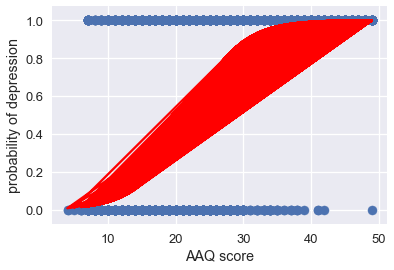

In [857]:
# plot the predicted probabilities of depression across the spectrum of AAQ
plt.scatter(X_train.AAQ.reshape(-1,1), y_depression_train.reshape(-1,1))
plt.plot(X_train.AAQ.reshape(-1,1), logreg.predict_proba(X_train.AAQ.reshape(-1,1))[:, 1], color='red')
plt.xlabel('AAQ score')
plt.ylabel('probability of depression');

### Test model accuracy

In [858]:
y_dep_preds = logreg.predict(X_test.AAQ.reshape(-1,1))

print('Depression Model Accuracy:', accuracy_score(y_depression_test, y_dep_preds))

('Depression Model Accuracy:', 0.88707280832095092)


### Perform cross validation

In [859]:
from sklearn import model_selection
from sklearn.model_selection import cross_val_score
kfold = model_selection.KFold(n_splits=10, random_state=7)
modelCV = LogisticRegression()
results = model_selection.cross_val_score(modelCV, X_train.AAQ.reshape(-1,1), y_depression_train.reshape(-1,1), cv=kfold, scoring='accuracy')
print("10-fold cross validation average accuracy: %.3f" % (results.mean()))

10-fold cross validation average accuracy: 0.884


### Confusion Matrix

In [860]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_depression_test, y_dep_preds)
confusion_df = pd.DataFrame(confusion_matrix, index = ['Actual: Depressed', 'Actual: Not Depressed'], columns = ['Predicted: Depressed', 'Predicted: Not Depressed'])
print(confusion_df)

                       Predicted: Depressed  Predicted: Not Depressed
Actual: Depressed                      1349                       128
Actual: Not Depressed                   176                      1039


In [861]:
from sklearn.metrics import classification_report
print(classification_report(y_depression_test, y_dep_preds))

             precision    recall  f1-score   support

          0       0.88      0.91      0.90      1477
          1       0.89      0.86      0.87      1215

avg / total       0.89      0.89      0.89      2692



- The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.
- The recall is intuitively the ability of the classifier to find all the positive samples.
- The F-beta score can be interpreted as a weighted harmonic mean of the precision and recall.
- The support is the number of occurrences of each class in y_test.

### ROC Curve

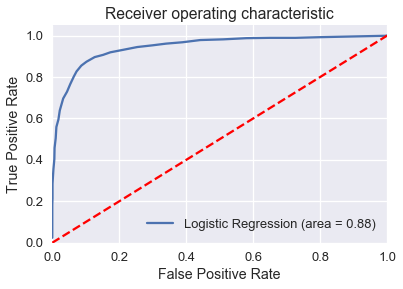

In [862]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_depression_test, logreg.predict(X_test.AAQ.reshape(-1,1)))
fpr, tpr, thresholds = roc_curve(y_depression_test, logreg.predict_proba(X_test.AAQ.reshape(-1,1))[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()